### 0. Explanation of the approach (Theory, reasoning)
**Pre-trained CLIP Embeddings vs. Raw EEG Data**

- CLIP embeddings: CLIP is a model that has been pre-trained on a massive dataset of images and text, so its embeddings contain rich semantic and visual information. These embeddings are already in a high-dimensional space that captures complex features of images and their associated textual descriptions.
- EEG data: EEG signals, on the other hand, are raw brain activity measurements that are highly noisy and subject-specific. The signal varies depending on individual neurological patterns, making it difficult to directly extract meaningful high-level features from EEG.

*Why EEG → CLIP works better:*

- Pre-trained semantic knowledge: CLIP embeddings already provide a well-established representation of visual and textual information. By mapping EEG signals to these rich, pre-trained embeddings, you’re leveraging the model’s learned understanding of the world and associating brain activity with meaningful, high-level features (such as whether the brain is processing visual or semantic information). In contrast, if you tried to map CLIP embeddings to EEG, you’d be trying to generate EEG signals from high-level, abstract representations, which is much more difficult because EEG signals don’t directly encode the structured semantics or visual information that CLIP does.

**Meaningful Associations (Visual vs. Semantic)**

The goal is to identify *when* the EEG data corresponds to visual vs. semantic information from CLIP embeddings. EEG data reflects brain activity related to perception, memory, or cognition, which directly aligns with visual or semantic processing in the brain.
*EEG → CLIP* allows us to train the model to understand which brain patterns correspond to which CLIP embeddings (visual or semantic), making it easier to match brain activity to its associated high-level features in CLIP.

*Why EEG → CLIP is preferred:*

The brain's neural responses are grounded in perception and cognition (which are visual or semantic in nature). This means that mapping EEG to CLIP allows you to uncover how different brain states (such as processing visual vs. semantic information) are reflected in the EEG data.

**!!** CLIP → EEG would not have a clear mapping because CLIP is designed to produce high-level embeddings, not brain signals. The relationship between EEG data and CLIP embeddings is more about mapping the brain's interpretation of images or text, rather than generating EEG signals from abstract embeddings.

**Implementation**
Things which one needs to consider about X in a linear regression:
- N x F (samples x features): N should always be more than F
- I have 4 images x 150 reps x 64 channels x 900 time points 
- y needs to be 4 x 150 x 768


### 1. Simulate captions (LLAVA rich)

In [ ]:
from embeddings_utils import run_blip_model_exp, run_llava_model_exp

project_dir = '/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings'
image_dir = '/projects/crunchie/boyanova/EEG_Things/eeg_prep/stimuli'
in_file_name = 'exp_images.npy'

run_blip_model_exp(project_dir, 
                    image_dir, 
                    input_file_name = in_file_name,
                    output_file_name = "exp_images_caps_blip.npy") 

run_llava_model_exp(project_dir, 
                    image_dir, 
                    input_file_name = in_file_name,
                    output_file_name = "exp_images_caps_llava.npy")

### 2. Extract CLIP embeddings

In [1]:
from embeddings_utils import clip_txt, clip_vis

project_dir = '/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings'
image_dir = '/projects/crunchie/boyanova/EEG_Things/eeg_prep/stimuli'
in_file_name = 'exp_images.npy'

clip_vis(project_dir,image_dir, input_file_name=in_file_name)
clip_txt(project_dir, image_dir,  language_model="llava", input_file_name = in_file_name, cap_name="exp_images_caps_llava.npy")


100%|██████████| 4/4 [00:00<00:00, 31184.42it/s]
/projects/crunchie/boyanova/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


torch.Size([4, 768])
Total Image Embeddings Shape: (4, 768)


100%|██████████| 4/4 [00:00<00:00, 145.81it/s]

torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])


### 3. Use a Simple Model
Start with a linear regression or a simple multi-layer perceptron (MLP):
- **Input:** Flattened EEG data (4 × 150 x 64 × 30 → 4*150=600 x 64) [x 90 (time points), / 2]; train 75% vs test 25% (LOIO approach)
- **Output:** CLIP embeddings (4 × 768).

A simple model is less likely to overfit your limited data and can still learn a basic mapping.


### 4. Code Skeleton idea (Ridge Regression, L2)


In [5]:
from eeg_decoding_utils import load_data, dump_data, average_across_points, random_eeg_pick, get_pseudotrials
import os
import numpy as np

from tqdm import tqdm
from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.model_selection import LeaveOneOut

from sklearn.discriminant_analysis import _cov
import scipy
import warnings
warnings.filterwarnings("ignore")

def cosine_similarity_numpy(x1, x2, axis=1, eps=1e-8):
    # Compute the dot product along the specified axis
    dot_product = np.sum(x1 * x2, axis=axis)
    
    # Compute the L2 norms
    norm_x1 = np.linalg.norm(x1, axis=axis)
    norm_x2 = np.linalg.norm(x2, axis=axis)
    
    # Compute cosine similarity with numerical stability
    return dot_product / (norm_x1 * norm_x2 + eps)

# -----------------------------
# Configurable Parameters
# -----------------------------
chunk_size = 1  # Number of time points to group together (set to 1 for no chunking)
alpha = 1.0     # Regularization strength for Ridge regression
loo = LeaveOneOut()

subjects = [2,3,4,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22]
conds = ["img", "fix"]

CLIP_names = ["CLIP_vis_exp_images.pickle", "CLIP_txt_exp_images_blip.pickle", "CLIP_txt_exp_images_llava.pickle"]
CLIP_conds = ["vis", "blip", "llava"]

CLIP_data_folder = "/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings/files"
EEG_data_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched"
EEG_encoding_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_encoding"
general_results = dict()
for clip_cond, CLIP_name in zip(CLIP_conds, CLIP_names):
    # -----------------------------
    # Load CLIP
    # -----------------------------
    CLIP_embeddings = load_data(os.path.join(CLIP_data_folder, CLIP_name))['embeddings']
    clip_dim = CLIP_embeddings.shape[-1]

    subject_data = []
    
    for cond in conds:
        subject_data = []    
        for sub in tqdm(subjects, desc = f"Subjects, for {cond}_{clip_cond}", position=1): 
            # -----------------------------
            # Load and prep EEG Data
            # -----------------------------
            EEG_data_file_name = f"eeg_things_{sub:04d}_{cond}.pickle"
            EEG_data = load_data(os.path.join(EEG_data_folder, EEG_data_file_name))
            EEG_data = average_across_points(EEG_data, window_size=10)

            ### Button press mask
            bt_press = EEG_data["button_press_mask"]
            EEG_data["eeg"] = EEG_data["eeg"][~bt_press]
            EEG_data["ids"] = EEG_data["ids"][~bt_press]
            EEG_data["block_num"] = EEG_data["block_num"][~bt_press]
            time = EEG_data["time"]

            # Select condition
            image_labels = [1, 2, 3, 4, 11, 12, 13, 14]
            mask = np.isin(EEG_data["ids"], image_labels)

            eeg_ = EEG_data["eeg"][mask]
            ids_ = EEG_data["ids"][mask]
            
            # mapping: 
            # 11 → 1, 12 → 2, 13 → 3, 14 → 4
            replacement_dict = {11: 1, 12: 2, 13: 3, 14: 4}

            # Convert the dictionary to a vectorized operation
            ids_ = np.vectorize(lambda x: replacement_dict.get(x, x))(ids_)

            # Get vars
            n_conditions = len(np.unique(ids_))
            n_sensors = eeg_.shape[1]
            n_time = eeg_.shape[-1]
            trial_lim = 300

            EEG_data = random_eeg_pick(eeg_, ids_, trial_lim)
            EEG_data, _ = get_pseudotrials(EEG_data, 150)
            n_trials = EEG_data.shape[1]

            # -----------------------------
            # Leave-One-Image-Out CV
            # -----------------------------
            
            cos = np.full((n_conditions, int(n_time/chunk_size)), np.nan)
            img_id = 0
            for train_image_idxs, test_image_idx in loo.split(np.arange(n_conditions)):
                
                # -----------------------------
                # Prepare Training Data
                # -----------------------------
                train_EEG = EEG_data[train_image_idxs]  # (3, trial_lim, 64, 90)
                train_CLIP = CLIP_embeddings[train_image_idxs]  # (3, 768)


                # -----------------------------
                # Prepare Test Data
                # -----------------------------
                test_EEG = EEG_data[test_image_idx]  # (trial_lim, 64, 90)
                test_CLIP = CLIP_embeddings[test_image_idx]  # (768,)
                
                # -----------------------------
                # Simulate for testing
                # -----------------------------
                #train_EEG = np.random.randn(*train_EEG.shape)
                #test_EEG = np.random.randn(*test_EEG.shape)

                # -----------------------------
                # Whiten data: Guggenmos approach (time)
                # -----------------------------
                sigma_ = np.empty((n_conditions-1, n_sensors, n_sensors))
                for c in range(n_conditions-1):
                    sigma_[c] = np.mean([_cov(train_EEG[c, :, :, t], shrinkage='auto')
                                        for t in range(n_time)], axis=0)
                                
                sigma = sigma_.mean(axis=0)
                sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)

                train_EEG = (train_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)
                test_EEG = (test_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)

                # Average across conditions
                sigma = sigma_.mean(axis=0)
                sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)

                # Apply whitening transformation
                train_EEG = (train_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)  
                test_EEG = (test_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)

                # Reshape: Collapse images and trials into one dimension
                train_EEG = train_EEG.reshape(-1, n_sensors, n_time)  # (3*trial_lim=900, 64, 90)
                test_EEG = test_EEG.reshape(-1, n_sensors, n_time)

                # -----------------------------
                # Train Separate Models for Each Time Point
                # -----------------------------
                t_id = 0
                for t in tqdm(range(0, n_time), desc = "Time", position=0):
                    
                    # Chunk time points if needed
                    train_X = train_EEG[:, :, t].reshape(450, -1)  # (900, chunk_size * 64)
                    test_X = test_EEG[ :, :, t].reshape(150, -1)  # (trial_lim, chunk_size * 64)

                    # Target (CLIP Embeddings)
                    train_y = np.repeat(train_CLIP, 150, axis = 0)  # Expand to (450, 768)
                    test_y = np.repeat(test_CLIP, 150, axis = 0)  # Expand to (trial_lim, 768)

                    # Normalize 
                    #train_y = train_y / np.linalg.norm(train_y, axis=1, keepdims=True)
                    #test_y = test_y / np.linalg.norm(test_y, axis=1, keepdims=True)
                    
                    # Ridge Regression vs Lasso Regression
                    model = Ridge(alpha=alpha)
                    model.fit(train_X, train_y)

                    # Predictions
                    test_preds = model.predict(test_X)

                    # Compute Cosine Similarity
                    sim = cosine_similarity_numpy(test_preds, test_y)   
            
                    cos[img_id, t] = np.mean(sim)

                img_id = img_id + 1
            subject_data.append(cos)

        print(np.array(subject_data).shape)
        general_results[f"{cond}_{clip_cond}"] = np.array(subject_data)
        dump_data(general_results, os.path.join(EEG_encoding_folder, "ridge_encoding_results.pkl"))
        
        

Subjects, for img_vis:   0%|          | 0/19 [01:23<?, ?it/s]


KeyboardInterrupt: 

### 4. Code Skeleton idea (Ridge Regression, L2) USING TORCH

In [ ]:
# -----------------------------
# Whiten data: Guggenmos approach (time)
# -----------------------------
sigma_ = np.empty((n_conditions-1, n_sensors, n_sensors))
for c in range(n_conditions-1):
    sigma_[c] = np.mean([_cov(train_EEG[c, :, :, t], shrinkage='auto')
                        for t in range(n_time)], axis=0)
                
sigma = sigma_.mean(axis=0)
sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)

train_EEG = (train_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)
test_EEG = (test_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)

# -----------------------------
# Whiten data: Guggenmos approach (epoch)
# -----------------------------
sigma_ = np.empty((n_conditions-1, n_sensors, n_sensors))  # Storage for covariance per condition
for c in range(n_conditions-1):
    sigma_[c] = np.mean([
        _cov(train_EEG[c, e].T, shrinkage='auto')  # Compute covariance for each trial
        for e in range(train_EEG.shape[1])  # Loop over trials
    ], axis=0)  # Average across trials

# Average across conditions
sigma = sigma_.mean(axis=0)
sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)

# Apply whitening transformation
train_EEG = (train_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)  
test_EEG = (test_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)  

In [2]:
import torch
from eeg_decoding_utils import load_data, dump_data, average_across_points, random_eeg_pick, get_pseudotrials, select_partition
import os
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import _cov
import scipy

def normalized_mse(preds, targets):
    mse = torch.nn.functional.mse_loss(preds, targets)  # Compute MSE
    var_y = torch.var(targets, unbiased=True)  # Compute variance of targets
    nmse = mse / var_y  # Normalize MSE
    return nmse.item()

# -----------------------------
# Configurable Parameters
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chunk_size = 1
loo = LeaveOneOut()

# Tunable parameter!
lambda_ridge = 1.0 

subjects = [2,3,4,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
conds = ["fix", "img"]
conds2 = ['det', 'rand']

CLIP_names = ["CLIP_vis_exp_images.pickle", "CLIP_txt_exp_images_llava.pickle", "CLIP_txt_exp_images_blip.pickle"]
CLIP_conds = ["vis", "llava", "blip"]
CLIP_data_folder = "/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings/files"

EEG_data_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched"
EEG_encoding_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_encoding"

cosine_results = dict()
loss_results = dict()

for clip_cond, CLIP_name in zip(CLIP_conds, CLIP_names):
    
    # -----------------------------
    # Load CLIP
    # -----------------------------

    CLIP_embeddings = load_data(os.path.join(CLIP_data_folder, CLIP_name))['embeddings']
    CLIP_embeddings = torch.tensor(CLIP_embeddings, dtype=torch.float64, device=device)
 
    for cond in conds:
        for cond2 in conds2:
            cosine_data = []
            loss_data = []   
            for sub in tqdm(subjects, desc=f"Subjects, for {cond}_{cond2}_{clip_cond}"):

                # -----------------------------
                # Load and prep EEG
                # -----------------------------
                EEG_data_file_name = f"eeg_things_{sub:04d}_{cond}.pickle"
                EEG_data = load_data(os.path.join(EEG_data_folder, EEG_data_file_name))
                EEG_data = average_across_points(EEG_data, window_size=10)

                bt_press = EEG_data["button_press_mask"]
                EEG_data["eeg"] = EEG_data["eeg"][~bt_press]
                EEG_data["ids"] = EEG_data["ids"][~bt_press]
                EEG_data["block_num"] = EEG_data["block_num"][~bt_press]

                eeg_, ids_ = select_partition(EEG_data, cond2)
                #replacement_dict = {11: 1, 12: 2, 13: 3, 14: 4}
                #ids_ = np.vectorize(lambda x: replacement_dict.get(x, x))(ids_)

                n_conditions = len(np.unique(ids_))
                n_sensors = eeg_.shape[1]
                n_time = eeg_.shape[-1]
                time = EEG_data["time"][np.arange(0, n_time, chunk_size)]
                trial_lim = 150

                EEG_data = random_eeg_pick(eeg_, ids_, trial_lim)
                EEG_data, _ = get_pseudotrials(EEG_data, 150)
                n_trials = EEG_data.shape[1]

                cos = np.full((n_conditions, len(time)), np.nan)
                track_mse = np.full((n_conditions, len(time)), np.nan)
                img_id = 0

                # -----------------------------
                # LOIO: Leave one image out procedure
                # Keeps Train/Test strictly seperated! 
                # -----------------------------
                for train_image_idxs, test_image_idx in loo.split(np.arange(n_conditions)):
                    
                    ### Simulate random data and inspect plots 
                    train_EEG = EEG_data[train_image_idxs]
                    train_CLIP = CLIP_embeddings[train_image_idxs]
                    
                    test_EEG = EEG_data[test_image_idx]
                    test_CLIP = CLIP_embeddings[test_image_idx]

                    # -----------------------------
                    # Simulate for testing
                    # -----------------------------
                    #train_EEG = np.random.randn(*train_EEG.shape)
                    #test_EEG = np.random.randn(*test_EEG.shape)

                    # -----------------------------
                    # Whiten data: Guggenmos approach (time)
                    # -----------------------------

                    sigma_ = np.empty((n_conditions-1, n_sensors, n_sensors))
                    for c in range(n_conditions-1):
                        sigma_[c] = np.mean([_cov(train_EEG[c, :, :, t], shrinkage='auto')
                                            for t in range(n_time)], axis=0)
                                    
                    sigma = sigma_.mean(axis=0)
                    sigma_inv = torch.tensor(scipy.linalg.fractional_matrix_power(sigma, -0.5), dtype=torch.float64, device=device)

                    train_EEG = torch.tensor(train_EEG, dtype=torch.float64, device=device)
                    test_EEG = torch.tensor(test_EEG, dtype=torch.float64, device=device)

                    train_EEG = (train_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)
                    test_EEG = (test_EEG.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)

                    train_EEG = train_EEG.reshape(-1, n_sensors, n_time)
                    test_EEG = test_EEG.reshape(-1, n_sensors, n_time)

                    # -----------------------------
                    # Regression for each time point
                    # -----------------------------
                    
                    t_id = 0
                    time_param = np.arange(0, n_time, chunk_size)
                    for t in range(0, len(time_param)):
                        
                        try:
                            if chunk_size == 1:
                                train_X = train_EEG[:, :, time_param[t]:time_param[t] + 1].reshape((n_conditions - 1) * n_trials, -1)
                                test_X = test_EEG[:, :, time_param[t]:time_param[t] + 1].reshape(n_trials, -1)
                            else:
                                train_X = train_EEG[:, :, time_param[t]:time_param[t+1]].reshape((n_conditions - 1) * n_trials, -1)
                                test_X = test_EEG[:, :, time_param[t]:time_param[t+1]].reshape(n_trials, -1)

                        except IndexError:
                            train_X = train_EEG[:, :, time_param[t]:].reshape((n_conditions - 1) * n_trials, -1)
                            test_X = test_EEG[:, :, time_param[t]:].reshape(n_trials, -1)
                            
                        train_y = train_CLIP.repeat(n_trials, 1)
                        test_y = test_CLIP.repeat(n_trials, 1)
                        
                        # Normalize train_y and test_y (No need!)
                        #train_y = train_y / torch.norm(train_y, dim=1, keepdim=True)
                        #test_y  = test_y  / torch.norm(test_y , dim=1, keepdim=True)

                        train_X_torch = train_X.to(device)
                        train_y_torch = train_y.to(device)
                        test_X_torch = test_X.to(device)

                        # Compute Ridge Regression solution: (X^T X + λI)θ = X^T Y using least squares 
                        I = torch.eye(train_X_torch.shape[1], device=device)  # Identity matrix
                        ridge_term = lambda_ridge * I  # Regularization term
                        theta, _, _, _ = torch.linalg.lstsq(train_X_torch.T @ train_X_torch + ridge_term, train_X_torch.T @ train_y_torch)
                        
                        test_preds = test_X_torch @ theta

                        sim = torch.nn.functional.cosine_similarity(test_preds, test_y, dim=1)
                        cos[img_id, t] = sim.mean().item()
                        #track_mse[img_id, t] = torch.nn.functional.mse_loss(test_preds, test_y)
                        track_mse[img_id, t] = normalized_mse(test_preds, test_y) 

                        t_id += 1

                    img_id += 1
                cosine_data.append(cos)
                loss_data.append(track_mse)

            print(np.array(cosine_data).shape)
            print(np.array(loss_data).shape)
            
            cosine_results[f"{cond}_{cond2}_{clip_cond}"] = np.array(cosine_data)
            loss_results[f"{cond}_{cond2}_{clip_cond}"] = np.array(loss_data)
            
            cosine_results["time"] = time
            loss_results["time"] = time
            
            dump_data(cosine_results, os.path.join(EEG_encoding_folder, "ridge_torch_encoding_cosine.pkl"))
            dump_data(loss_results, os.path.join(EEG_encoding_folder, "ridge_torch_encoding_mse.pkl"))

Subjects, for fix_det_vis: 100%|██████████| 21/21 [00:57<00:00,  2.75s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for fix_rand_vis: 100%|██████████| 21/21 [00:55<00:00,  2.66s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_det_vis: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_rand_vis: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for fix_det_llava: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for fix_rand_llava: 100%|██████████| 21/21 [00:53<00:00,  2.57s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_det_llava: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_rand_llava: 100%|██████████| 21/21 [00:52<00:00,  2.52s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for fix_det_blip: 100%|██████████| 21/21 [00:52<00:00,  2.50s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for fix_rand_blip: 100%|██████████| 21/21 [00:54<00:00,  2.57s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_det_blip: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]


(21, 4, 90)
(21, 4, 90)


Subjects, for img_rand_blip: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]

(21, 4, 90)
(21, 4, 90)


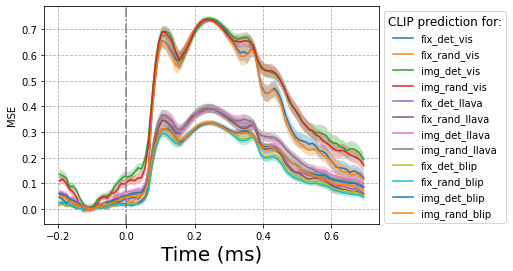

In [3]:
import matplotlib.pyplot as plt
condition_keys = [key for key in list(cosine_results.keys()) if key != "time"]
for key in condition_keys:
    mean_data = np.mean(cosine_results[key], axis=(0,1))
    plt.plot(time, mean_data, label = key)
    sem_data = np.std(cosine_results[key], axis=(0, 1), ddof=1) / np.sqrt(len(subjects))
    plt.fill_between(
        time,
        mean_data - sem_data,   
        mean_data + sem_data,   
        alpha=0.3
    )
 
plt.grid(True, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title="CLIP prediction for:", title_fontsize=12)
#plt.axhline(y=0,color='tab:gray', linestyle='-.')
plt.axvline(x=0.0, color='tab:gray', linestyle='-.')

plt.xlabel("Time (ms)", fontsize=20)
plt.ylabel("MSE")
plt.show()

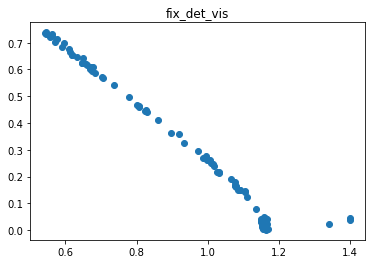

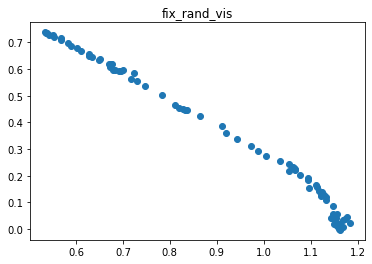

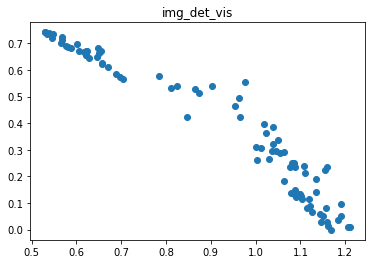

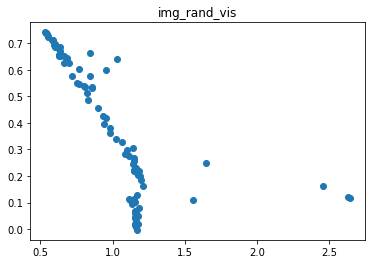

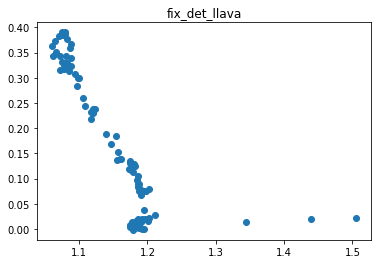

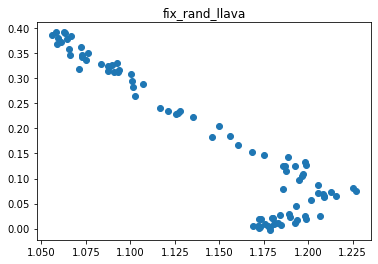

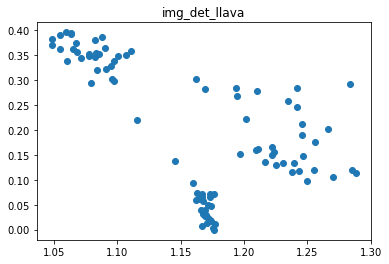

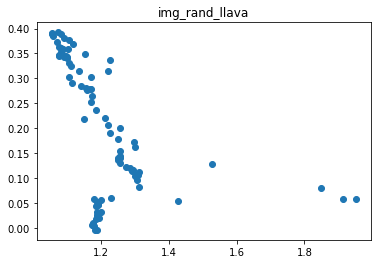

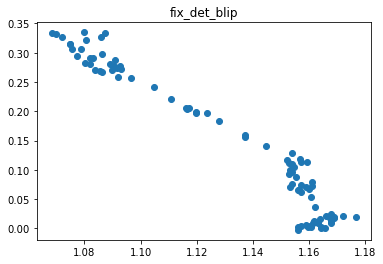

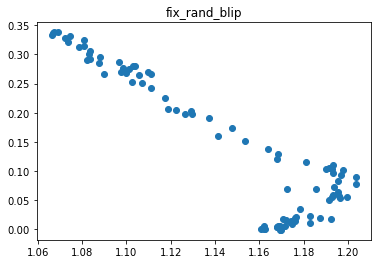

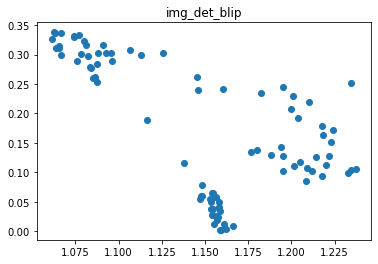

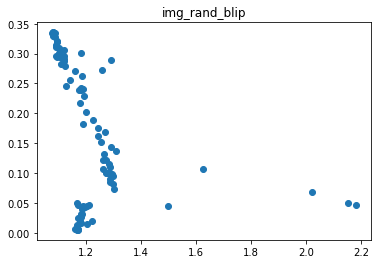

In [7]:
for key in condition_keys:
    plt.scatter(np.mean(loss_results[key], axis = (0, 1)), np.mean(cosine_results[key], axis = (0, 1))) 
    plt.title(key)
    plt.show()

### 5. Reconstruct Images given the embeddings

In [ ]:
from diffusers import DiffusionPipeline
import torch
import os

project_dir = "/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings"
cache_dir = os.path.join(project_dir, "models")


device = "cuda" if torch.cuda.is_available() else "cpu"


pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", cache_dir = cache_dir).to(device)

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]


/projects/crunchie/boyanova/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [10]:
# Generate image using the dual_guided method
with torch.no_grad():
    generated_image = pipe.dual_guided(
        text_embeds=text_embedding,
        image_embeds=image_embedding,
    ).images[0]

generated_image.show()

TypeError: VersatileDiffusionPipeline.dual_guided() got an unexpected keyword argument 'text_embeds'

In [11]:
from eeg_decoding_utils import load_data
import os 
import torch
import numpy as np

CLIP_data_folder = "/projects/crunchie/boyanova/EEG_Things/Grouping-Embeddings/files"
CLIP_name = "CLIP_vis_exp_images.pickle"
CLIP_embeddings = load_data(os.path.join(CLIP_data_folder, CLIP_name))['embeddings']
# Decode the latents (embedding) back to an image
# Check if 'embedding' is a numpy array, and convert it to a PyTorch tensor if necessary
embedding = CLIP_embeddings[0]
if isinstance(embedding, np.ndarray):
    embedding = torch.tensor(embedding)

# Ensure the tensor is of type float32
embedding = embedding.to(torch.float32).reshape(-1,1)
latents = pipe.decode(embedding)

# To visualize or process the image, you might need to convert it to a PIL Image or a tensor.
image = pipe.numpy_to_pil(latents)

# Show the image (if running in an environment that supports displaying images)
image.show()

AttributeError: 'StableDiffusionPipeline' object has no attribute 'decode'